In [9]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from hmmlearn import hmm
from utils import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
def process_signals(error_file, u_file):
    """
    Processes error_signal and u_signal from CSV files, groups their columns into lists of 4.

    Args:
        error_file (str): Path to the CSV file for error_signal.
        u_file (str): Path to the CSV file for u_signal.

    Returns:
        tuple: Two lists - one for error_signal and one for u_signal, each containing grouped arrays (4 per group).
    """
    # Load the CSV data
    error_signal = np.loadtxt(error_file, delimiter=',')
    u_signal = np.loadtxt(u_file, delimiter=',')

    # Initialize lists for storing grouped arrays (4 per group)
    error_not_distracted_list = []
    u_signal_not_distracted_list = []

    # Grouping error_signal in steps of 4
    for i in range(0, error_signal.shape[1], 4):
        error_group = [error_signal[:, j] for j in range(i, min(i + 4, error_signal.shape[1]))]
        error_not_distracted_list.append(error_group)

    # Grouping u_signal in steps of 4
    for i in range(0, u_signal.shape[1], 4):
        u_group = [u_signal[:, j] for j in range(i, min(i + 4, u_signal.shape[1]))]
        u_signal_not_distracted_list.append(u_group)

    return error_not_distracted_list, u_signal_not_distracted_list


In [11]:
# error_not_distracted, u_signal_not_distracted = process_signals(error_file= '/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file='/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv')
error_not_distracted, u_signal_not_distracted = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/u.csv')
error_distracted, u_signal_distracted         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/u.csv')

In [12]:
person_idx = 0
scaler = StandardScaler()

# combine the entire list in the priors
error_not_distracted = np.concatenate(error_not_distracted[person_idx])
u_not_distracted = np.concatenate(u_signal_not_distracted[person_idx])

error_not_distracted = scaler.fit_transform(error_not_distracted.reshape(-1, 1)).flatten()
u_not_distracted = scaler.fit_transform(u_not_distracted.reshape(-1, 1)).flatten()

error_derivative_not_distracted = np.diff(error_not_distracted)
u_signal_derivative_not_distracted = np.diff(u_not_distracted)

X_not_distracted = np.column_stack((error_not_distracted[:-1], u_not_distracted[:-1]))

error_distracted = np.concatenate(error_distracted[person_idx])
u_distracted = np.concatenate(u_signal_distracted[person_idx])

error_distracted = scaler.fit_transform(error_distracted.reshape(-1, 1)).flatten()
u_distracted = scaler.fit_transform(u_distracted.reshape(-1, 1)).flatten()

X_test = np.column_stack((error_distracted, u_distracted))

# Fit the HMM on non-distracted data
model = hmm.GaussianHMM(n_components=1, covariance_type='full', n_iter=100)
model.fit(X_not_distracted)

# Parameters for detection
threshold = -50 


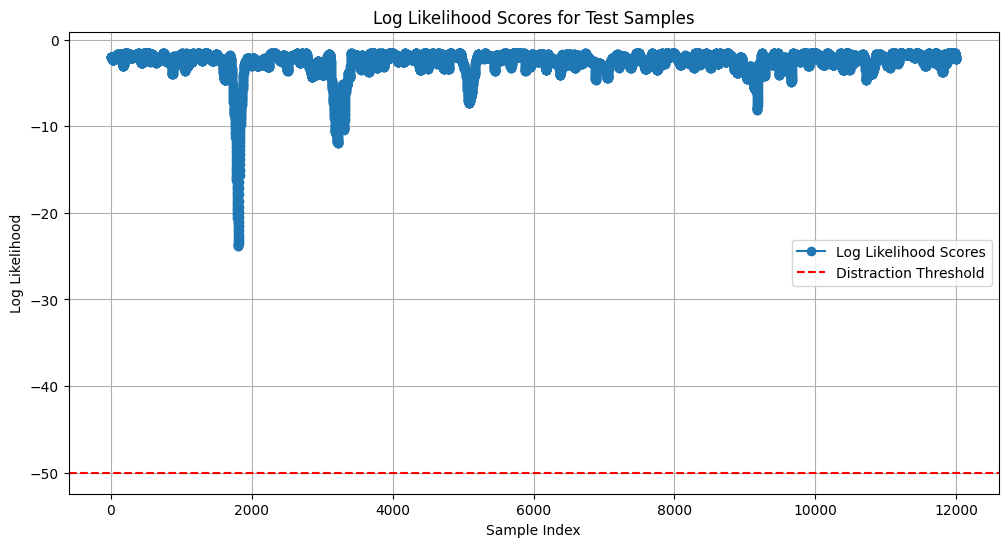

In [13]:
# Detect distractions in each sample
log_likelihoods = []

tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/mdist.csv', delimiter=',')
tc_test_col = tc_test[:, 1]
X_test = X_test[:12000]

for i, sample in enumerate(X_test):
    log_likelihood = model.score(np.array([sample]))  # Log likelihood for the single sample
    log_likelihoods.append(log_likelihood)  # Append the score to the list

   
# Create a mask for tc_test == 1 and tc_test == 0
mask_1 = tc_test_col == 1
mask_0 = tc_test_col == 0

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods, marker='o', label='Log Likelihood Scores')
plt.axhline(y=threshold, color='r', linestyle='--', label='Distraction Threshold')
plt.title('Log Likelihood Scores for Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Log Likelihood')
plt.legend()
plt.grid()
plt.show()

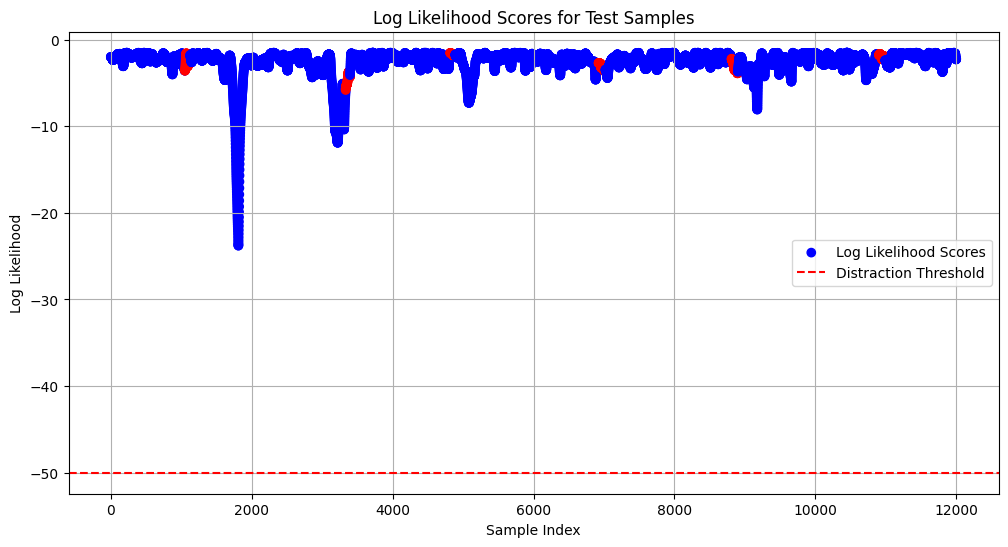

In [15]:
# Plotting log likelihood scores with conditional coloring
plt.figure(figsize=(12, 6))

# Color coding based on tc_test values
colors = ['red' if tc == 1 else 'blue' for tc in tc_test_col]

# Plot log likelihoods with respective colors
plt.scatter(range(len(log_likelihoods)), log_likelihoods, c=colors, label='Log Likelihood Scores')

plt.axhline(y=threshold, color='red', linestyle='--', label='Distraction Threshold')
plt.title('Log Likelihood Scores for Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Log Likelihood')
plt.legend()
plt.grid()
plt.show()

Observed: 1.8, Predicted Mean: 1.7696923144353331, Predicted Std: 0.23942142830775798, Probability Density: 1.6529792900906772
Observed: 2.2, Predicted Mean: 1.6524371572251237, Predicted Std: 0.1941803099203902, Probability Density: 0.038550038061718715
Observed: 1.0, Predicted Mean: 2.0015041141463312, Predicted Std: 0.19418030992038907, Probability Density: 3.4388185410983658e-06
Observed: 3.0, Predicted Mean: 2.1769908138781564, Predicted Std: 0.23942142830775706, Probability Density: 0.0045275091849463715
Observed: 7.0, Predicted Mean: -0.04486845858765295, Predicted Std: 1.1724268204299135, Probability Density: 4.915842269690959e-09


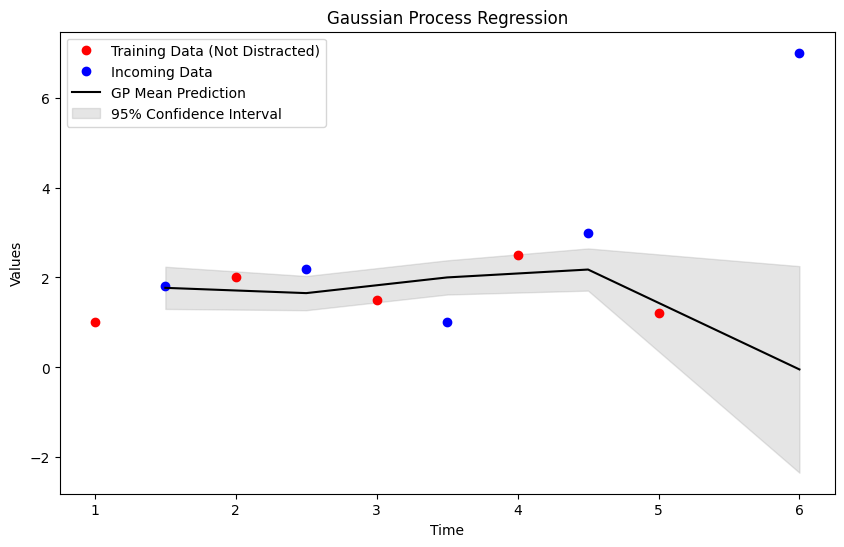

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Simulated not distracted time series data
X_train = np.array([[1], [2], [3], [4], [5]]).astype(float)
y_train = np.array([1, 2, 1.5, 2.5, 1.2]).astype(float)

# Incoming data (some distracted, some not)
X_test = np.array([[1.5], [2.5], [3.5], [4.5], [6]]).astype(float)
y_test = np.array([1.8, 2.2, 1.0, 3.0, 7.0]).astype(float)  # Including distracted data at 6.0

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Create and fit the GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

# Make predictions for the incoming data
y_mean, y_std = gp.predict(X_test, return_std=True)

# Calculate probabilities for each point in incoming data
probabilities = []
for i in range(len(X_test)):
    mean = y_mean[i]
    std = y_std[i]
    obs = y_test[i]

    # Compute probability density
    prob_density = (1 / np.sqrt(2 * np.pi * std**2)) * np.exp(-0.5 * ((obs - mean)**2) / std**2)
    probabilities.append(prob_density)
    print(f'Observed: {obs}, Predicted Mean: {mean}, Predicted Std: {std}, Probability Density: {prob_density}')

# Plotting for visualization
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training Data (Not Distracted)')
plt.plot(X_test, y_test, 'bo', label='Incoming Data')
plt.plot(X_test, y_mean, 'k-', label='GP Mean Prediction')
plt.fill_between(X_test.flatten(), 
                 y_mean - 1.96 * y_std, 
                 y_mean + 1.96 * y_std, 
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


/home/mihai/Thesis/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Predicted next state: 0.0000, Actual next state: -0.8169
No anomaly detected. Error: 0.8169 is within threshold: 0.5.


ValueError: 'y' is not 1-dimensional

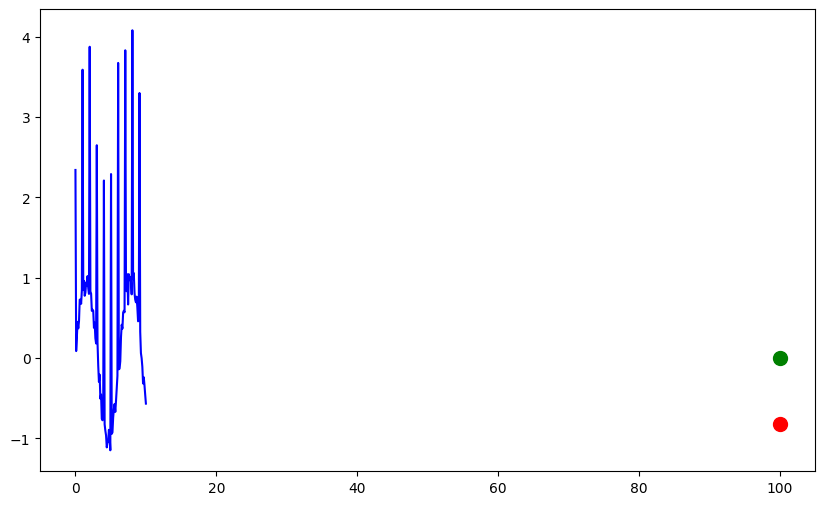

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate some synthetic time series data (normal + some anomalies)
np.random.seed(42)
time_steps = np.linspace(0, 10, 100)
y_train = np.sin(time_steps) + np.random.normal(0, 0.1, time_steps.shape)  # Normal data
y_train[::10] += np.random.normal(3, 0.5, size=y_train[::10].shape)  # Adding anomalies

# Prepare training data for the model
# Using past 5 points to predict the next point
X_train = np.array([y_train[i:i+5] for i in range(len(y_train)-5)])  # 5 previous values
y_labels = y_train[5:]  # The next point is the label

# Fit the Gaussian Process model on historical data
kernel = C(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train, y_labels)

# Generate test data (including some new samples)
incoming_data = np.array([y_train[-5:]])  # Last 5 points for prediction
predicted_next, std_dev = gp.predict(incoming_data, return_std=True)

# Simulate the actual incoming sample for comparison
actual_next = np.sin(time_steps[-1] + 0.1) + np.random.normal(0, 0.1)  # Next point
print(f'Predicted next state: {predicted_next[0]:.4f}, Actual next state: {actual_next:.4f}')

# Calculate the confidence interval (e.g., 95% CI)
lower_bound = predicted_next - 1.96 * std_dev
upper_bound = predicted_next + 1.96 * std_dev

# Anomaly detection
error = np.abs(actual_next - predicted_next[0])
threshold = 0.5  # Define an error threshold for anomaly detection

# Compare actual next state with confidence interval
if (actual_next < lower_bound) or (actual_next > upper_bound):
    print(f'Anomaly detected! Error: {error:.4f} exceeds threshold: {threshold}.')
else:
    print(f'No anomaly detected. Error: {error:.4f} is within threshold: {threshold}.')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time_steps, y_train, label='Historical Data', color='blue')
plt.scatter(len(y_train), actual_next, color='red', label='Actual Incoming Sample', s=100)
plt.scatter(len(y_train), predicted_next[0], color='green', label='Predicted Next State', s=100)
plt.fill_betweenx([lower_bound, upper_bound], len(y_train), len(y_train) + 1, color='orange', alpha=0.5, label='95% Confidence Interval')
plt.axhline(y=lower_bound, color='orange', linestyle='--')
plt.axhline(y=upper_bound, color='orange', linestyle='--')
plt.title('Anomaly Detection using Gaussian Process Regression')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()